# Transfer Learning Job Profiles

The following graphs and statistics capture the profile of the transfer learning experiments.

In [2]:
# NOTEBOOK VARIABLES

experiment = "sharded_1"
clusters_file = "clusters_pck6.csv"

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

dir_prefix = "experiment_data/job_profiles"

clusters_df = pd.read_csv(f"{dir_prefix}/clusters_pck6.csv", header=0).sort_values(by="cluster_id")
cluster_models_stats_df = pd.read_csv(f"{dir_prefix}/cluster_model_stats_{experiment}.csv", header=0).sort_values(by="cluster_id")
centroid_models_stats_df = pd.read_csv(f"{dir_prefix}/centroid_stats_{experiment}.csv", header=0).sort_values(by="cluster_id")
sequential_model_stats_df = pd.read_csv(f"{dir_prefix}/sequential_stats.csv", header=0).sort_values(by="cluster_id")
sequential_tasks_df = pd.read_csv(f"{dir_prefix}/experiment_profile_sequential.csv", header=1)
transfer_learn_tasks_df = pd.read_csv(f"{dir_prefix}/experiment_profile_{experiment}.csv", header=1)


In [3]:
def human_time(difference_ms):
    return datetime.timedelta(milliseconds=difference_ms)

class Cluster:
    
    def __init__(self, cluster_id):
        self.id = cluster_id
        self.gis_joins = []
        self.center_gis_join = ""
        self.records_count = 0
        

class Task:
    
    def __init__(self, task_id, name, begin, end, time_seconds, gis_join="", cluster_id=-1):
        self.id = task_id
        self.name = name
        self.begin = begin
        self.end = end
        self.time_seconds = time_seconds
        self.gis_join = gis_join
        self.cluster_id = cluster_id
        
    def __repr__(self):
        return repr(f"Task: id={self.id}, name={self.name}, begin={self.begin}, end={self.end}, time_seconds={self.time_seconds}")
    
    
class CentroidModelTasks:
    
    def __init__(self):
        self.run_tasks = []
        
        
class ClusterLRModelTasks:
    
    def __init__(self):
        self.run_tasks = {}
        self.persist_tasks = {}
        self.train_all_tasks = {}
        self.train_tasks = {}


In [4]:
transfer_learn_experiment_task = None # Overarching task for experiment
sequential_experiment_task = None # Overarching task for experiment

centroid_model_tasks = CentroidModelTasks() # Tasks for centroid model training
transfer_learn_cluster_tasks = ClusterLRModelTasks() # Tasks for transfer-learned cluster training
sequential_cluster_tasks = ClusterLRModelTasks() # Tasks for sequential cluster training

clusters_pca = {} # Stats about cluster
clusters_seq = {} # Stats about cluster

In [5]:
# ----- Transfer Learn Tasks -----

for i, row in transfer_learn_tasks_df.iterrows():
    if (i == 0):
        transfer_learn_experiment_task = Task(i, row["name"], row["begin"], row["end"], row["time_seconds"])
    else:
        parts = row["name"].split(";")
        task_type = parts[0]
        task_name = parts[1]
        task_gis_join = parts[2][len("gisJoin=")+1:]
        task_cluster_id = str(parts[3][len("clusterId="):])

        new_task = Task(i, task_name, row["begin"], row["end"], row["time_seconds"], 
                        gis_join=task_gis_join, cluster_id=task_cluster_id)

        if (task_type == "CentroidModel"):

            if ("run()" in task_name):
                centroid_model_tasks.run_tasks.append(new_task)


        elif (task_type == "ClusterLRModels"):

            if ("run()" in task_name):

                if task_cluster_id not in transfer_learn_cluster_tasks.run_tasks:
                    transfer_learn_cluster_tasks.run_tasks[task_cluster_id] = [new_task]
                else:
                    transfer_learn_cluster_tasks.run_tasks[task_cluster_id].append(new_task)

            elif ("Cluster" in task_name):

                if task_cluster_id not in transfer_learn_cluster_tasks.persist_tasks:
                    transfer_learn_cluster_tasks.persist_tasks[task_cluster_id] = [new_task]
                else:
                    transfer_learn_cluster_tasks.persist_tasks[task_cluster_id].append(new_task)

            elif ("Train all" in task_name):

                if task_cluster_id not in transfer_learn_cluster_tasks.train_all_tasks:
                    transfer_learn_cluster_tasks.train_all_tasks[task_cluster_id] = [new_task]
                else:
                    transfer_learn_cluster_tasks.train_all_tasks[task_cluster_id].append(new_task)

            elif ("train()" in task_name):

                if task_cluster_id not in transfer_learn_cluster_tasks.train_tasks:
                    transfer_learn_cluster_tasks.train_tasks[task_cluster_id] = [new_task]
                else:
                    transfer_learn_cluster_tasks.train_tasks[task_cluster_id].append(new_task)

# ----- Sequential Tasks -----
    
for i, row in sequential_tasks_df.iterrows():
    if (i == 0):
        sequential_experiment_task = Task(i, row["name"], row["begin"], row["end"], row["time_seconds"])
    else:
        parts = row["name"].split(";")
        task_type = parts[0]
        task_name = parts[1]
        task_gis_join = parts[2][len("gisJoin=")+1:]
        cluster_id = int(parts[3][len("clusterId="):])
        task_cluster_id = str(cluster_id)

        new_task = Task(i, task_name, row["begin"], row["end"], row["time_seconds"], 
                        gis_join=task_gis_join, cluster_id=task_cluster_id)


        if (task_type == "ClusterLRModels"):

            if ("run()" in task_name):

                if task_cluster_id not in sequential_cluster_tasks.run_tasks:
                    sequential_cluster_tasks.run_tasks[task_cluster_id] = [new_task]
                else:
                    sequential_cluster_tasks.run_tasks[task_cluster_id].append(new_task)

            elif ("Cluster" in task_name):

                if task_cluster_id not in sequential_cluster_tasks.persist_tasks:
                    sequential_cluster_tasks.persist_tasks[task_cluster_id] = [new_task]
                else:
                    sequential_cluster_tasks.persist_tasks[task_cluster_id].append(new_task)

            elif ("Train all" in task_name):
                
                numRecords = int(parts[5][len("numRecords="):])
                #print(cluster_id)
                clusters_seq[cluster_id] = Cluster(cluster_id)
                clusters_seq[cluster_id].records_count = numRecords
                #print(numRecords)
                
                if task_cluster_id not in sequential_cluster_tasks.train_all_tasks:
                    sequential_cluster_tasks.train_all_tasks[task_cluster_id] = [new_task]
                else:
                    sequential_cluster_tasks.train_all_tasks[task_cluster_id].append(new_task)

            elif ("train()" in task_name):

                if task_cluster_id not in sequential_cluster_tasks.train_tasks:
                    sequential_cluster_tasks.train_tasks[task_cluster_id] = [new_task]
                else:
                    sequential_cluster_tasks.train_tasks[task_cluster_id].append(new_task)
                    
                    
# ----- PCA Clusters -----
    
for i, row in clusters_df.iterrows():
    cluster_id = row["cluster_id"]
    if cluster_id not in clusters_pca:
        clusters_pca[cluster_id] = Cluster(cluster_id)
    
    if row["is_center"]:
        clusters_pca[cluster_id].center_gis_join = row["gis_join"]
    else:
        clusters_pca[cluster_id].gis_joins.append(row["gis_join"])
        
# ----- Seq Clusters -----
    
for i, row in sequential_model_stats_df.iterrows():
    cluster_id = row["cluster_id"]
    clusters_seq[cluster_id].gis_joins.append(row["gis_join"])
        

In [6]:
len(clusters_seq[0].gis_joins)

55

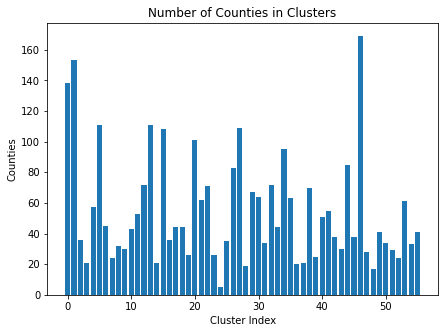

In [18]:
# ---- Plot Clusters Bar Chart -----




transfer_learning_cluster_sizes = []
sequential_cluster_sizes = []
sequential_cluster_numrecords = []

for i in range(0,56):
    transfer_learning_cluster_sizes.append(len(clusters_pca[i].gis_joins)+1)
    sequential_cluster_sizes.append(len(clusters_seq[i].gis_joins))
    sequential_cluster_numrecords.append(clusters_seq[i].records_count)
    

    
fig, ax = plt.subplots(1,1,figsize=(7,5))

ax.bar(range(0,56), transfer_learning_cluster_sizes, label="PC Cluster Queues")
ax.set_title("Number of Counties in Clusters")
ax.set_ylabel("Counties")
ax.set_xlabel("Cluster Index")

plt.show()

fig.savefig('experiment_data/pc_cluster_sizes.png',
           format='png',
           dpi=200,
           bbox_inches='tight')


plt.show()

In [ ]:
# ---- Centroid Models Plotting -----

centroid_run_tasks = []
for i in range(0,56):
    run_task = centroid_model_tasks.run_tasks[i]
    centroid_run_tasks.append(run_task.time_seconds)


total_centroid_time = human_time(centroid_model_tasks.run_tasks[-1].end 
                                 - centroid_model_tasks.run_tasks[0].begin)

total_experiment_time = transfer_learn_experiment_task.time_seconds

print("Experiment %s Time: %s seconds" % (experiment, total_experiment_time))
print("Total time taken to train/evaluate 56 centroid models:", total_centroid_time)



# Create a figure
figure, axis = plt.subplots(3, 1, figsize=(10,20))


# For Centroid Task Times
axis[0].plot(centroid_run_tasks, label="Total Time")
axis[0].plot((centroid_models_stats_df["time_ms"]/1000.0).to_list(), label="Exhaustive Training Time")
axis[0].set_title("Centroid Modeling Task Times")
axis[0].set_ylabel("Seconds")
axis[0].set_xlabel("Centroid Index")
axis[0].legend()

# For Iterations
axis[1].bar(range(0, 56),centroid_models_stats_df["iterations"].to_list())
axis[1].set_title("Centroid Model Iterations")
axis[1].set_ylabel("Iterations")
axis[1].set_xlabel("Centroid Index")


# For RMSE
axis[2].plot(centroid_models_stats_df["rmse"].to_list())
axis[2].set_title("Centroid Model Test RMSE")
axis[2].set_ylabel("RMSE")
axis[2].set_xlabel("Centroid Index")

# show plot
plt.show()

In [ ]:
# ---- Cluster Transfer Learning Model Plotting -----

clusters_run_time_seconds = [val[0].time_seconds for val in transfer_learn_cluster_tasks.run_tasks.values()]
seq_clusters_run_time_seconds = [val[0].time_seconds for val in sequential_cluster_tasks.run_tasks.values()]


# Create a figure
plt.figure(figsize=(12,7))

# For Cluster Training End-to-End Time
plt.plot(clusters_run_time_seconds, label="PC Clusters E2E Time")
plt.plot(seq_clusters_run_time_seconds, label="Normal Clusters E2E Time")
plt.title("Complete Cluster Training E2E Time")
plt.ylabel("Seconds")
plt.xlabel("Cluster Index")
plt.legend()

plt.show()

In [ ]:
# ---- Cluster Model Plotting -----

cluster_models_stats_df
centroid_models_stats_df
sequential_model_stats_df

times_ms    = [[],[]]
iterations  = [[],[]]
num_records = [[],[]]


for i, seq_row in sequential_model_stats_df.iterrows():
    gis_join = seq_row["gis_join"]
    
    times_ms[0].append(seq_row["time_ms"]/1000.0)
    iterations[0].append(seq_row["iterations"])
    num_records[0].append(seq_row["num_records"])
    
    search_df = cluster_models_stats_df.loc[ cluster_models_stats_df["gis_join"] == gis_join ]
    if search_df.size > 0:
        row = search_df.iloc[0]
        times_ms[1].append(row["time_ms"]/1000.0)
        iterations[1].append(row["iterations"])
    else: # Centroid model
        search_df = centroid_models_stats_df.loc[ centroid_models_stats_df["gis_join"] == gis_join ]
        times_ms[1].append(0)
        iterations[1].append(search_df.iloc[0]["iterations"])
        
    

In [ ]:
fig = plt.figure(figsize =(10, 7))
  
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
  
# Creating plot
#ax.plot(times_ms[0])
ax.plot(times_ms[1])
#bp = ax.boxplot(times_ms)

plt.show()

In [ ]:
import numpy as np
gis_join_df = pd.read_csv("experiment_data/rows.csv", header=0)

X1 = gis_join_df["relative_humidity_percent"].to_list()
Y1 = gis_join_df["label"].to_list()

X2 = np.linspace(0, 100, 100)
Y2 = -0.13438541379122257 * X2 + 281.6580

plt.figure(figsize=(15,7))
plt.plot(X1,Y1, "ro")
plt.plot(X2,Y2, "g-")
plt.xlabel("Relative Humidity Percent")
plt.ylabel("Temperature Kelvin")
plt.show()

In [ ]:
no_tl_model_stats_df = pd.read_csv("experiment_data/job_profiles/no_tl_model_stats.csv", header=0)
tl_model_stats_df = pd.read_csv("experiment_data/job_profiles/tl_model_stats.csv", header=0)

tl_model_stats_df = tl_model_stats_df.sort_values("gis_join")
no_tl_model_stats_df = no_tl_model_stats_df.sort_values("gis_join")

without_centroids_df = tl_model_stats_df[tl_model_stats_df["is_centroid"] == False]

without_centroids_df

In [ ]:
import math

# Create a figure
figure, axis = plt.subplots(4, 1, figsize=(7,20))


# For Iterations

yint = range(min(tl_model_stats_df["iterations"].to_list()), math.ceil(max(no_tl_model_stats_df["iterations"].to_list()))+1)

axis[0].plot(no_tl_model_stats_df["iterations"].to_list(), "x", label="Non-Transfer-Learned Models")
axis[0].plot(tl_model_stats_df["iterations"].to_list(), "+", label="Transfer-Learned Models")
axis[0].set_title("Linear Regression Iterations to Convergence")
axis[0].set_ylabel("Iterations")
axis[0].set_xlabel("Model Index")
axis[0].set_yticks(yint)
axis[0].legend()

# For RMSE
axis[1].plot(no_tl_model_stats_df["rmse"].to_list(), "x", label="Non-Transfer-Learned Models")
axis[1].plot(tl_model_stats_df["rmse"].to_list(), "+", label="Transfer-Learned Models")

axis[1].set_title("Testing RMSE")
axis[1].set_ylabel("RMSE")
axis[1].set_xlabel("Model Index")
axis[1].legend()


# For Time

axis[2].plot( (no_tl_model_stats_df["time_ms"] / 1000.0).to_list(), "x", label="Non-Transfer-Learned Models")
axis[2].plot( (without_centroids_df["time_ms"] / 1000.0).to_list(), "+", label="Transfer-Learned Models")
axis[2].set_title("Time to Training Convergence")
axis[2].set_ylim([0,10])
axis[2].set_ylabel("Time (Seconds)")
axis[2].set_xlabel("Model Index")
axis[2].legend()

# # For Time
axis[3].plot( tl_model_stats_df["num_records"].to_list(), "k.")
axis[3].set_title("Observations by County")
axis[3].set_ylabel("Observation Count")
axis[3].set_xlabel("Model Index")

plt.show()


In [ ]:
# Create a figure
fig, ax = plt.subplots(1,1,figsize=(7,5))

print(no_tl_model_stats_df["iterations"].mean(), no_tl_model_stats_df["iterations"].std())
print(tl_model_stats_df["iterations"].mean(), tl_model_stats_df["iterations"].std())



# For Iterations

yint = range(min(tl_model_stats_df["iterations"].to_list()), math.ceil(max(no_tl_model_stats_df["iterations"].to_list()))+1)
ax.plot(no_tl_model_stats_df["iterations"].to_list(), "x", label="Non-Transfer-Learned Models")
ax.plot(tl_model_stats_df["iterations"].to_list(), "+", label="Transfer-Learned Models")
ax.set_title("Linear Regression Iterations to Convergence")
ax.set_ylabel("Iterations")
ax.set_xlabel("Model Index")
ax.set_yticks(yint)
ax.legend()

plt.show()

fig.savefig('experiment_data/lr_tl_iterations.png',
           format='png',
           dpi=200,
           bbox_inches='tight')

In [ ]:
# Create a figure

fig, ax = plt.subplots(1,1,figsize=(7,5))


# For Iterations

ax.plot(no_tl_model_stats_df["rmse"].to_list(), "x", label="Non-Transfer-Learned Models")
ax.plot(tl_model_stats_df["rmse"].to_list(), "+", label="Transfer-Learned Models")
ax.set_title("Linear Regression Testing RMSE")
ax.set_ylabel("RMSE")
ax.set_xlabel("Model Index")
ax.legend()

plt.show()

fig.savefig('experiment_data/lr_tl_rmse.png',
           format='png',
           dpi=200,
           bbox_inches='tight')

In [ ]:
# Create a figure

# create figure and axis objects with subplots()
# fig,ax = plt.subplots()
# # make a plot
# # twin object for two different y-axis on the sample plot
# ax2=ax.twinx()
# # make a plot with different y-axis using second axis object

# ax2.set_ylabel("Observation Count")
# ax.plot((no_tl_model_stats_df["time_ms"] / 1000.0).to_list(), "x", label="Non-Transfer-Learned Models")
# ax.plot((without_centroids_df["time_ms"] / 1000.0).to_list(), "+", label="Transfer-Learned Models")
# ax2.plot(tl_model_stats_df["num_records"].to_list(), "g.", zorder=-1)
# # set x-axis label
# ax.set_xlabel("Model Index")
# # set y-axis label
# ax.set_ylabel("Time (Seconds)")


# plt.show()
# save the plot as a file

fig, ax = plt.subplots(1,1,figsize=(7,5))

print((no_tl_model_stats_df["time_ms"] / 1000.0).mean(), (no_tl_model_stats_df["time_ms"] / 1000.0).std())
print((without_centroids_df["time_ms"] / 1000.0).mean(), (without_centroids_df["time_ms"] / 1000.0).std())

ax.plot( (no_tl_model_stats_df["time_ms"] / 1000.0).to_list(), "x", label="Non-Transfer-Learned Models")
ax.plot((without_centroids_df["time_ms"] / 1000.0).to_list(), "+", label="Transfer-Learned Models")
ax.set_title("Linear Regression Time to Convergence")
ax.set_ylim([0,10])
ax.set_ylabel("Time (Seconds)")
ax.set_xlabel("Model Index")
ax.legend()

plt.show()

fig.savefig('experiment_data/lr_tl_time.png',
           format='png',
           dpi=200,
           bbox_inches='tight')


NameError: name 'tl_model_stats_df' is not defined

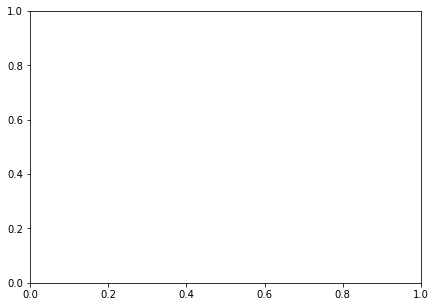

In [43]:
# Create a figure

fig, ax = plt.subplots(1,1,figsize=(7,5))

ax.plot(tl_model_stats_df["num_records"].to_list(), "k.")
ax.set_title("Observations by County")
ax.set_ylabel("Observation Count")
ax.set_xlabel("Model Index")

plt.show()

fig.savefig('experiment_data/lr_tl_observations.png',
           format='png',
           dpi=200,
           bbox_inches='tight')

In [122]:
dir_pref = "experiment_data/cluster_metrics/single_machine"
no_tl_df = pd.read_csv(f"{dir_pref}/no_transfer_learning.csv", header=0)
tl_df = pd.read_csv(f"{dir_pref}/transfer_learning.csv", header=0)

no_tl_df

,timestamp,CPU_ALL:User%,CPU_ALL:Sys%,MEM:memtotal,MEM:active,MEM:inactive,NET:eno1-write-KB/s,NET:eno1-read-KB/s,NET:eno2-write-KB/s,NET:eno2-read-KB/s,DISKREAD:sda,DISKREAD:sdb,DISKREAD:sdc,DISKREAD:sdd,DISKWRITE:sda,DISKWRITE:sdb,DISKWRITE:sdc,DISKWRITE:sdd
0,1621543938,4.0,4.0,31828.8,12341.9,5535.5,63.1,35.6,0.0,0.0,0.0,0.0,0.0,0.0,248.9,0.0,0.0,0.0
1,1621543939,0.9,1.5,31828.8,12341.9,5535.5,14.7,11.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1621543940,1.5,1.7,31828.8,12341.9,5535.5,57.3,20.9,0.0,0.0,0.0,0.0,0.0,0.0,79.8,0.0,0.0,0.0
3,1621543941,1.1,1.4,31828.8,12341.9,5535.5,15.8,8.3,0.0,0.0,0.0,0.0,0.0,0.0,23.9,0.0,0.0,0.0
4,1621543942,3.1,2.7,31828.8,12352.7,5535.5,75.3,17.3,0.0,0.0,0.0,0.0,0.0,0.0,183.6,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,1621544087,39.9,2.3,31828.8,14005.1,5666.3,38.1,25.1,0.0,0.0,0.0,0.0,0.0,0.0,215.5,0.0,0.0,0.0
147,1621544088,28.3,3.7,31828.8,14025.5,5664.3,467.1,58.3,0.0,0.0,0.0,0.0,0.0,0.0,295.5,0.0,0.0,0.0
148,1621544089,38.4,2.2,31828.8,14121.2,5664.2,404.3,25.8,0.0,0.0,0.0,0.0,0.0,0.0,99.8,0.0,0.0,0.0
149,1621544090,37.7,3.6,31828.8,14179.0,5655.5,93.4,21.7,0.0,0.0,0.0,0.0,0.0,0.0,107.8,0.0,0.0,0.0


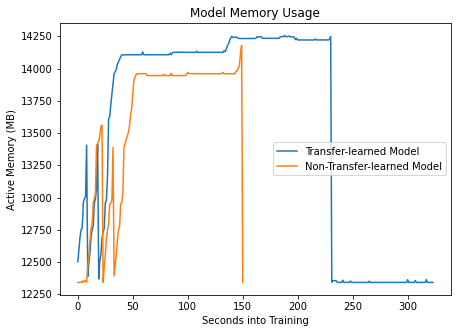

In [123]:
fig, ax = plt.subplots(1,1,figsize=(7,5))

ax.plot(tl_df["MEM:active"].to_list(), "-", label="Transfer-learned Model")
ax.plot(no_tl_df["MEM:active"].to_list(), "-", label="Non-Transfer-learned Model")
ax.set_title("Model Memory Usage")
ax.set_xlabel("Seconds into Training")
ax.set_ylabel("Active Memory (MB)")
ax.legend()

plt.show()

fig.savefig('experiment_data/lr_tl_memory_pressure.png',
           format='png',
           dpi=200,
           bbox_inches='tight')


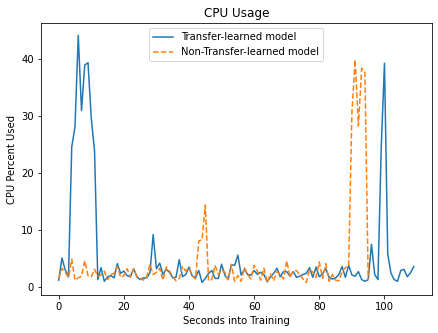

In [136]:
fig, ax = plt.subplots(1,1,figsize=(7,5))

tl_df_2 = tl_df.iloc[130:240]
no_tl_df_2 = no_tl_df.iloc[55:]


tl_df_3 = tl_df_2.iloc[80:]
no_tl_df_3 = no_tl_df_2.iloc[80:]

ax.plot(tl_df_2["CPU_ALL:User%"].to_list(), "-", label="Transfer-learned model")
ax.plot(no_tl_df_2["CPU_ALL:User%"].to_list(), "--", label="Non-Transfer-learned model")
ax.set_title("CPU Usage")
ax.set_xlabel("Seconds into Training")
ax.set_ylabel("CPU Percent Used")
ax.legend()

plt.show()

fig.savefig('experiment_data/lr_tl_cpu_usage.png',
           format='png',
           dpi=200,
           bbox_inches='tight')


In [25]:
no_tl_vm_df = pd.read_csv(f"experiment_data/cluster_metrics/single_machine/non_tl_VM.csv", header=0)
tl_vm_df = pd.read_csv(f"experiment_data/cluster_metrics/single_machine/tl_VM.csv", header=0)
tl_vm_2_df = pd.read_csv(f"experiment_data/cluster_metrics/single_machine/tl_2_VM.csv", header=0)

tl_vm_df

,VM,Paging and Virtual Memory,nr_dirty,nr_writeback,nr_unstable,nr_page_table_pages,nr_mapped,nr_slab_reclaimable,pgpgin,pgpgout,...,pgrefill_dma,pgsteal_high,pgsteal_normal,pgsteal_dma,pgscan_kswapd_high,pgscan_kswapd_normal,pgscan_kswapd_dma,pgscan_direct_high,pgscan_direct_normal,pgscan_direct_dma
0,VM,T0001,3,0,100922,20723,2861345,168396,0,152,...,0,0,0,0,0,0,0,0,0,0
1,VM,T0002,0,0,100922,20793,2861376,168397,0,456,...,0,0,0,0,0,0,0,0,0,0
2,VM,T0003,14,0,100922,20852,2861378,168393,0,120,...,0,0,0,0,0,0,0,0,0,0
3,VM,T0004,0,0,100922,20933,2861384,168410,0,264,...,0,0,0,0,0,0,0,0,0,0
4,VM,T0005,0,0,100922,20944,2861387,168411,0,556,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,VM,T0321,0,0,100922,20521,2861896,168405,0,196,...,0,0,0,0,0,0,0,0,0,0
321,VM,T0322,0,0,100922,20534,2861895,168405,0,48,...,0,0,0,0,0,0,0,0,0,0
322,VM,T0323,0,0,100922,20534,2861897,168405,0,40,...,0,0,0,0,0,0,0,0,0,0
323,VM,T0324,0,0,100922,20534,2861897,168405,0,56,...,0,0,0,0,0,0,0,0,0,0


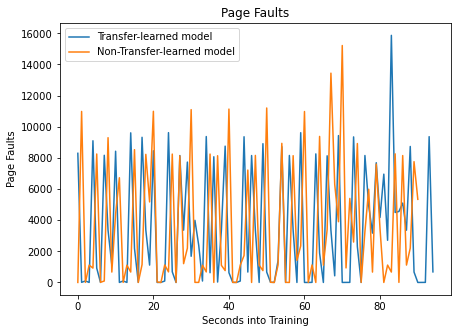

In [28]:
fig, ax = plt.subplots(1,1,figsize=(7,5))

tl_fixed = tl_vm_df.iloc[55:150]
no_tl_fixed = no_tl_vm_df.iloc[55:]

ax.plot(tl_fixed["pgfault"].to_list(), "-", label="Transfer-learned model")
ax.plot(no_tl_fixed["pgfault"].to_list(), "-", label="Non-Transfer-learned model")
ax.set_title("Page Faults")
ax.set_xlabel("Seconds into Training")
ax.set_ylabel("Page Faults")
ax.legend()

plt.show()